<a href="https://colab.research.google.com/github/DarshanDinni/learn_pytorch/blob/main/01_Pytorch_Workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Importing the data

import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
# Creating the data using the below formula
# Y = mX + c - linear regression formula

weight = 0.5
bias = 0.7

X = torch.arange(0, 1, 0.02).unsqueeze(dim=1)
y = weight * X + bias

print("Tensor X: \n", X[:5])
print("Tensor y: \n", y[:5])

Tensor X: 
 tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800]])
Tensor y: 
 tensor([[0.7000],
        [0.7100],
        [0.7200],
        [0.7300],
        [0.7400]])


In [12]:
X.shape, y.shape

(torch.Size([50, 1]), torch.Size([50, 1]))

In [15]:
# Spliting the data into train and test set

X_train, y_train = X[:40], y[:40]
X_test, y_test = X[40:], y[40:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([40, 1]),
 torch.Size([40, 1]),
 torch.Size([10, 1]),
 torch.Size([10, 1]))

In [23]:
# Visualize the data

def plot_graph(training_data=X_train, testing_data=X_test, training_label=y_train, testing_label=y_test, prediction=None):
  # Setting the size of the graph
  plt.figure(figsize=(10, 7))

  # Plotting training data
  plt.scatter(X_train, y_train, c='b',s=4, label='Training data points')

  # Plotting testing data
  plt.scatter(X_test, y_test, c='r',s=4, label='Testing data points')

  # Plotting prediction data
  if prediction != None:
    plt.scatter(testing_data, prediction, c='g', s=4, label='Prediction data points')

  plt.legend()
  plt.show()

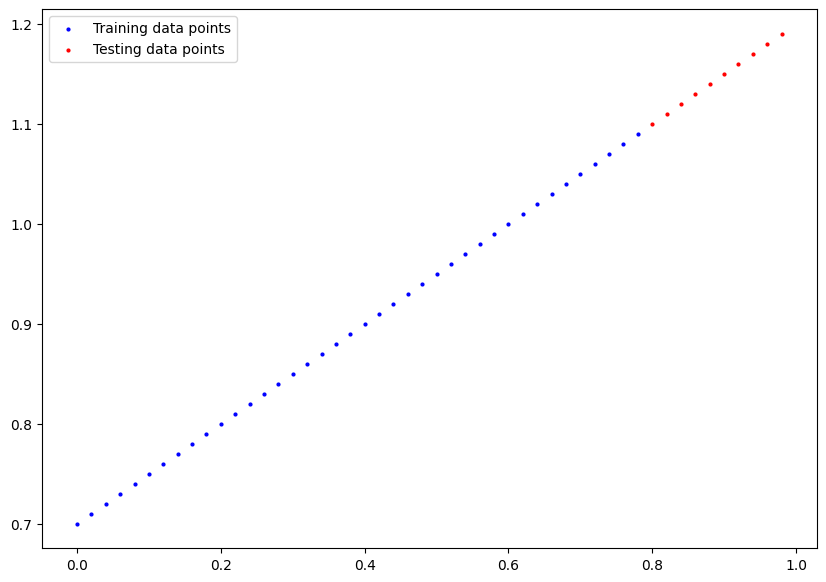

In [24]:
plot_graph()

In [25]:
# Build model

# Creating linear regression model which inherits nn.Module which has all the neural network modules to work with
class LinearRegressionModel(nn.Module):

  # Defining the constructor
  def __init__(self):
    super().__init__()
    self.weight = nn.Parameter(torch.randn(1, dtype=float))
    self.bias = nn.Parameter(torch.randn(1, dtype=float))

  # As we are inheriting the nn.Module we need to overwrite the forward function
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weight * x + self.bias

In [30]:
# Creating a seed value
torch.manual_seed(42)

# Creating the instance of the linear regression model
model_0 = LinearRegressionModel()

In [32]:
# Checking the parameters set for our model
model_0.state_dict()

OrderedDict([('weight', tensor([0.3367], dtype=torch.float64)),
             ('bias', tensor([0.1288], dtype=torch.float64))])

In [33]:
# So our goal is to let the model learn so that it can better fit the data by finding the correct values for weight and bias
# The correct values of weight and bias are as below
weight, bias

(0.5, 0.7)

In [35]:
# Code run under this inference mode gets better performance by disabling view tracking and version counter bumps
with torch.inference_mode():
  # Making the prediction with testing data points
  y_prediction = model_0(X_test)

y_prediction

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], dtype=torch.float64)

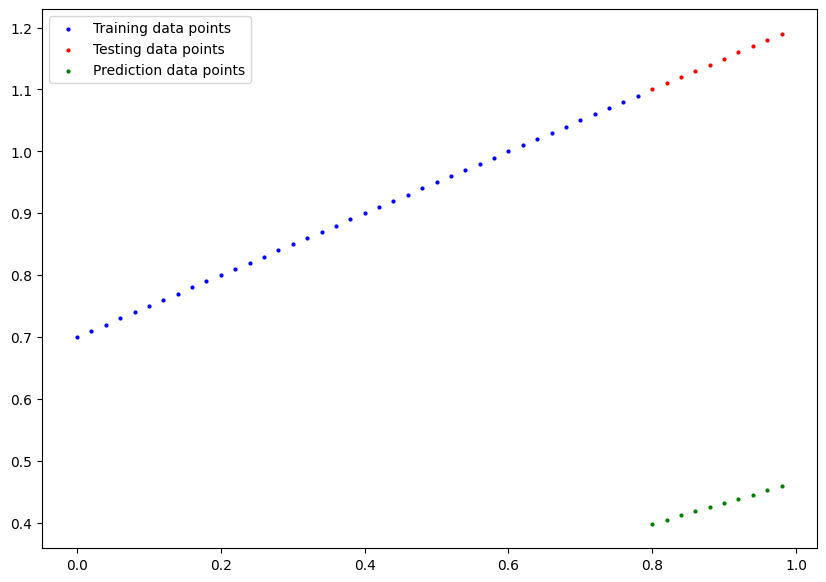

In [36]:
# Plotting the prediction data points to check the how model is performing

plot_graph(prediction=y_prediction)

In [ ]:
# As from the above graph that its obvious that the model's prediction of bad so we need to train the model so that it can learn how to predict the values as close as possible
# So to train the model we need to create optimizer and loss function
# Loss function:
# Optimizer:
